## Initialize

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = "final_images"
train_directory = root + "/train"
validation_directory = root + "/validation"
test_directory = root + "/test"
img_width, img_height, batch_size = 256, 256, 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = validation_ds.class_names
print(class_names)

Found 1747 files belonging to 9 classes.
['chinese_apple', 'lantana', 'negative', 'parkinsonia', 'parthenium', 'prickly_acacia', 'rubber_vine', 'siam_weed', 'snake_weed']


2022-11-26 17:02:14.473398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:02:14.486757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:02:14.487700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:02:14.489425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Visualize few samples

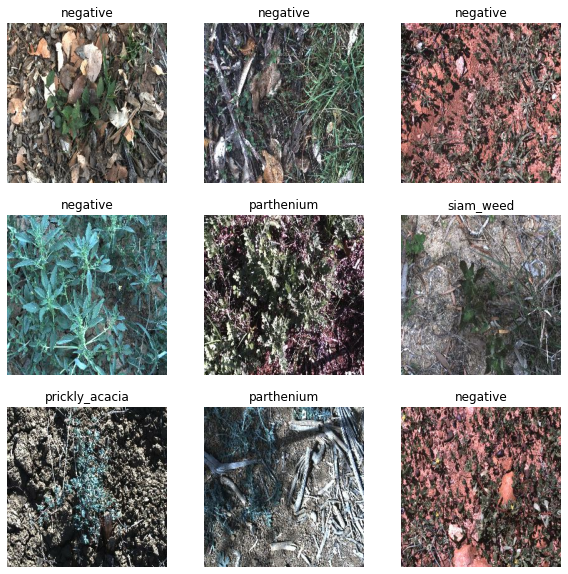

In [8]:
for images, labels in train_ds:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        for index, label in enumerate(labels[i]):
            if label == 1:
                plt.title(class_names[int(index)])
        plt.axis("off")
    break

In [9]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

## Model Config

In [4]:
from tensorflow import keras
from keras import layers, models

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)     

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'cnn-2-con-bnorm.h5',
    monitor="val_categorical_accuracy",
    mode="max", verbose=1, save_best_only=True)

## Train

In [15]:
history = model.fit(train_ds,
    epochs=100,
    validation_data=validation_ds,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 1.1700 - categorical_accuracy: 0.5903
Epoch 1: val_categorical_accuracy improved from -inf to 0.58729, saving model to drive/MyDrive/Colab Notebooks/best-models/cnn-batch-norm.h5
438/438 [==============================] - 94s 187ms/step - loss: 1.1700 - categorical_accuracy: 0.5903 - val_loss: 1.2140 - val_categorical_accuracy: 0.5873
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 0.8985 - categorical_accuracy: 0.6810
Epoch 2: val_categorical_accuracy improved from 0.58729 to 0.63537, saving model to drive/MyDrive/Colab Notebooks/best-models/cnn-batch-norm.h5
438/438 [==============================] - 80s 183ms/step - loss: 0.8985 - categorical_accuracy: 0.6810 - val_loss: 1.0755 - val_categorical_accuracy: 0.6354
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 0.7752 - categorical_accuracy: 0.7272
Epoch 3: val_categorical_accuracy did not improve from 0.63537
438/438 [

## Training Results

### Loss vs Epoch

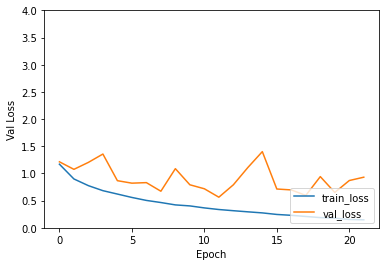

In [16]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

### Accuracy vs Epoch

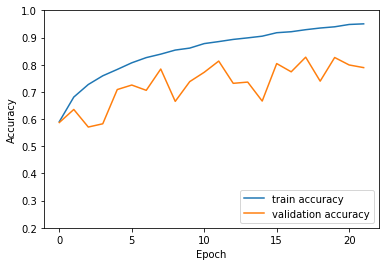

In [17]:
plt.plot(history.history['categorical_accuracy'], label='train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

## Testing

### Load and evaluate

In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_directory, label_mode="categorical",
    seed=40,
    image_size=(img_height, img_width),
    batch_size=batch_size)

best_model = keras.models.load_model("cnn-2-con-bnorm.h5")
test_loss, test_acc = best_model.evaluate(test_ds, verbose=2)

Found 1760 files belonging to 9 classes.


2022-11-26 17:02:41.337897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


55/55 - 9s - loss: 0.5826 - categorical_accuracy: 0.8284 - 9s/epoch - 169ms/step


## Testing Results

### Visualize confusion matrix

In [6]:
import seaborn as sns

In [7]:
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    y_true.extend(np.argmax(label_batch, axis=1))
    y_pred.extend(np.argmax(best_model.predict(image_batch), axis=1))

1/1 [==============================] - 0s 37ms/step


<AxesSubplot:>

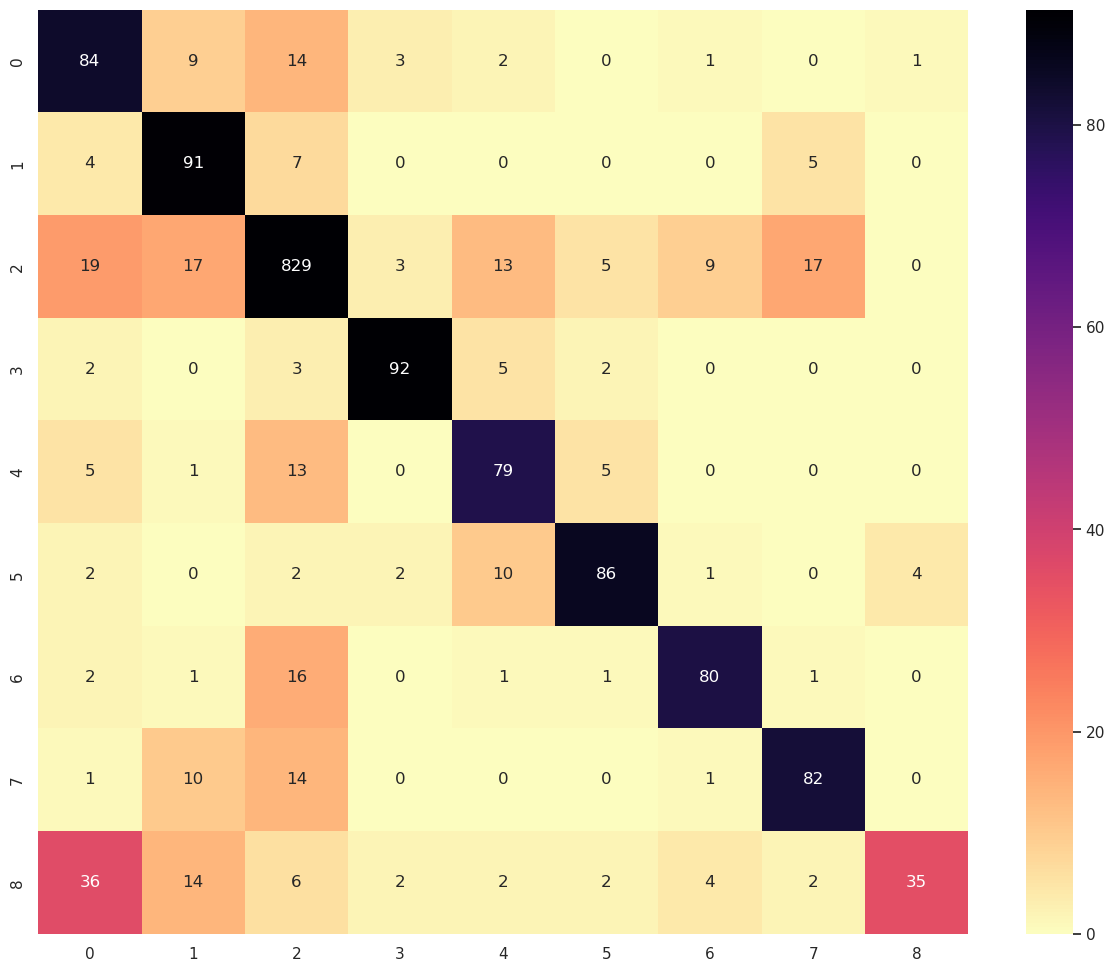

In [8]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='d', robust=True)

<AxesSubplot:>

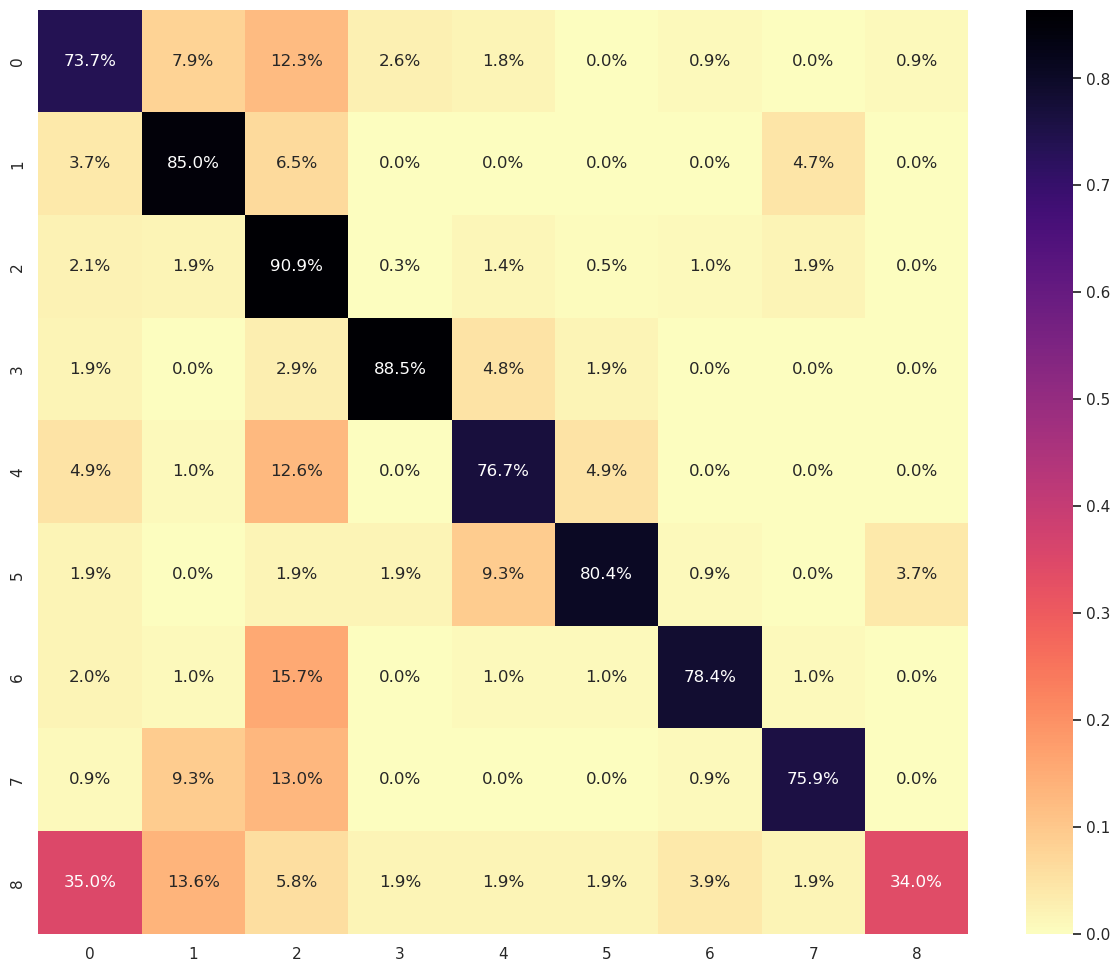

In [9]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
confusion_matrix = confusion_matrix.astype(np.float32) / confusion_matrix.sum(axis=1)[:, np.newaxis]
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='.1%', robust=True)

In [10]:
y_true_val = []
y_pred_val = []

for image_batch, label_batch in validation_ds:
    y_true_val.extend(np.argmax(label_batch, axis=1))
    y_pred_val.extend(np.argmax(best_model.predict(image_batch), axis=1))

1/1 [==============================] - 2s 2s/step


<AxesSubplot:>

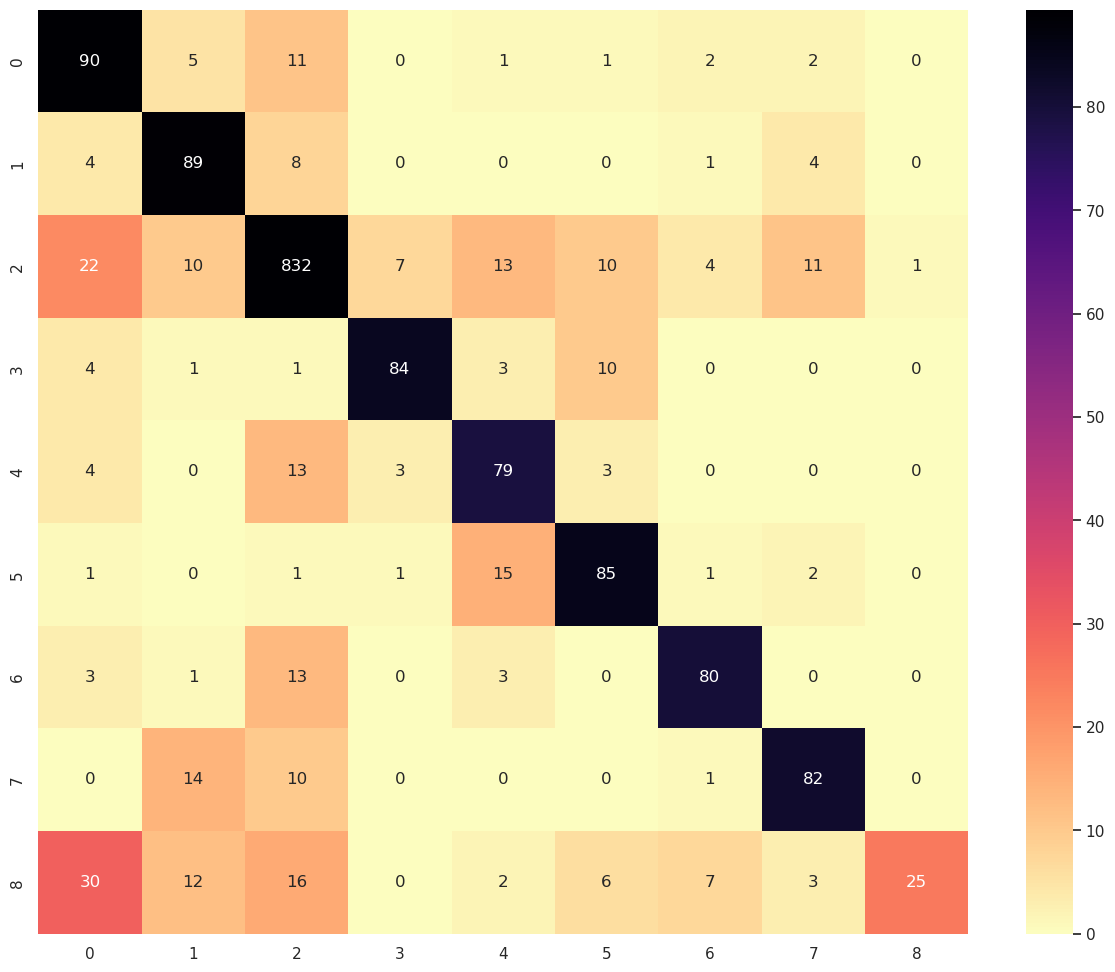

In [11]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true_val, y_pred_val)
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='d', robust=True)

<AxesSubplot:>

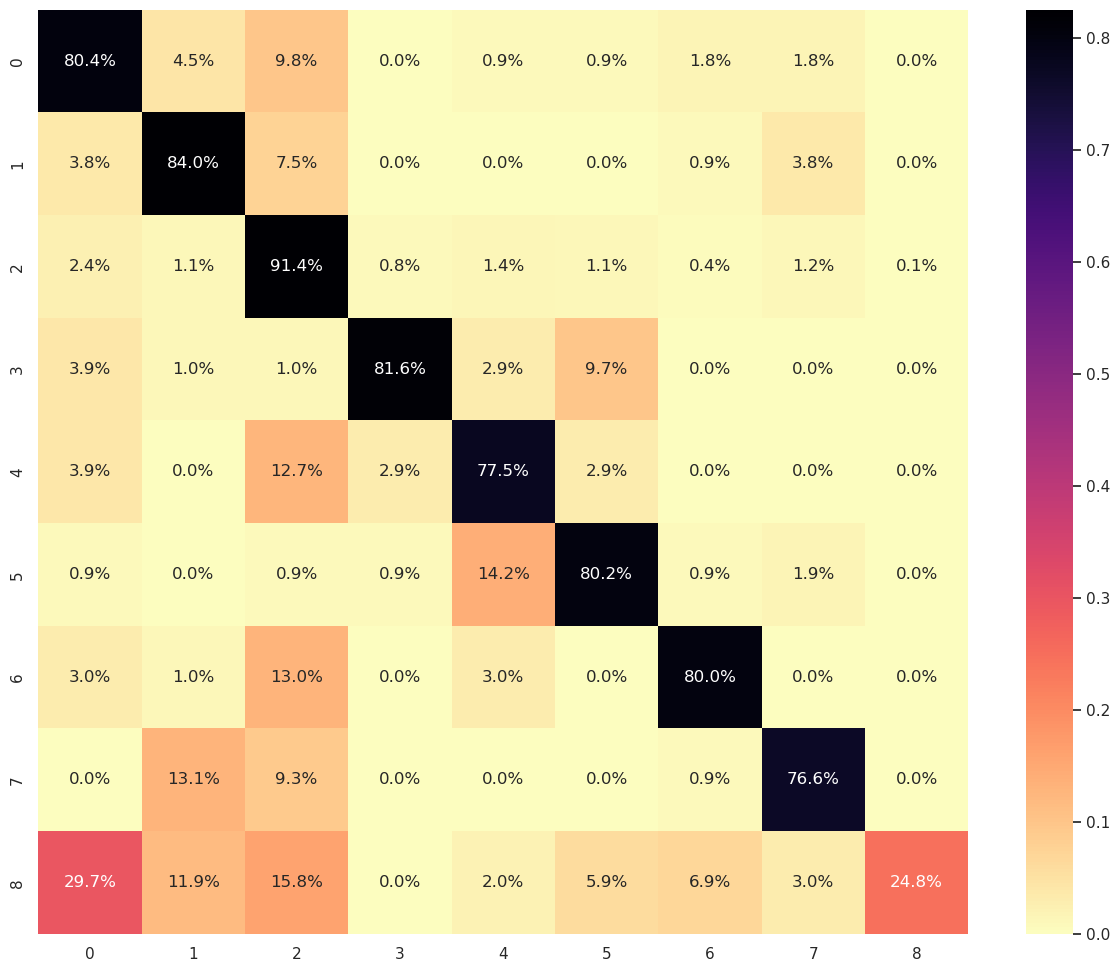

In [12]:
sns.set(rc = {'figure.figsize':(15,12)})
confusion_matrix = tf.math.confusion_matrix(y_true_val, y_pred_val).numpy()
confusion_matrix = confusion_matrix.astype(np.float32) / confusion_matrix.sum(axis=1)[:, np.newaxis]
color_map = sns.color_palette("magma_r", as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, cmap=color_map, fmt='.1%', robust=True)

### Interpreting

In [9]:
import matplotlib.cm as cm
from PIL import Image
from keras.models import Model
import cv2

In [10]:
model = keras.models.load_model("cnn-2-con-bnorm.h5")
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
last_layer = conv2D_layers[0]
layer_count = len(conv2D_layers)

In [11]:
# Decode predictions made by a model into a human readable format 
# https://stackoverflow.com/questions/49259361/valueerror-decode-predictions-expects-a-batch-of-predictions-i-e-a-2d-array
def decode_predictions(preds, top=1):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple((i, class_names[i], pred[i])) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

# Guided GradCAM
# https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
def get_ggradcam(model, img_array, layer_name, pred_index=None, eps=1e-8):
    gradModel = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output,
        model.output])
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    return heatmap

# superimpose heatmap on image
# https://keras.io/examples/vision/grad_cam/#configurable-parameters
def get_superimposed(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

def show_grad_cam(model, img, layer, show_original=True, show_heat=True, show_imposed=True, pred_index=None, alpha=0.4):
    curr_grad_cam = get_ggradcam(model, np.expand_dims(img, axis=0), layer, pred_index=pred_index)
    curr_superimposed = get_superimposed(img, curr_grad_cam, alpha=alpha)
    plt.figure(figsize=(10, 4))
    if show_original:
        ax = plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original Image')
    if show_heat:
        ax = plt.subplot(1, 3, 2)
        plt.imshow(curr_grad_cam)
        plt.axis('off')
        plt.title(layer + ' GGrad-CAM heatmap')
    if show_imposed:
        ax = plt.subplot(1, 3, 3)
        plt.imshow(curr_superimposed)
        plt.axis('off')
        plt.title('Superimposed')
    plt.tight_layout()

### Random

1/1 [==============================] - 0s 136ms/step
Predicted: [(2, 'negative', 0.99368083), (1, 'lantana', 0.0061461465), (8, 'snake_weed', 8.736971e-05), (5, 'prickly_acacia', 6.474951e-05), (4, 'parthenium', 1.5721638e-05), (6, 'rubber_vine', 2.7341562e-06), (7, 'siam_weed', 1.3782201e-06), (0, 'chinese_apple', 9.608304e-07), (3, 'parkinsonia', 2.063358e-09)]


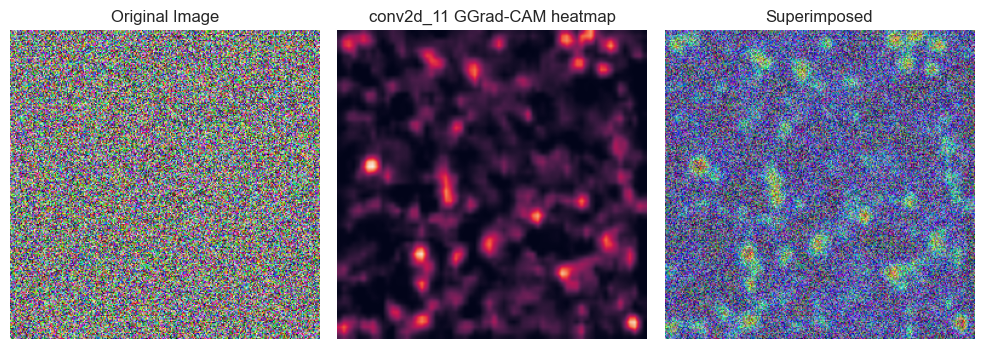

In [12]:
image = np.random.rand(256, 256, 3) * 255
image = image.astype(np.uint8)

preds = model.predict(np.expand_dims(image, axis=0))
print("Predicted:", decode_predictions(preds, top=9)[0])
show_grad_cam(model, image, last_layer)

### Regular Image

In [13]:
image = np.array(Image.open("final_images/test/chinese_apple/20161207-111112-0.jpg"))

1/1 [==============================] - 0s 40ms/step
Predicted: [(0, 'chinese_apple', 0.99735177)]


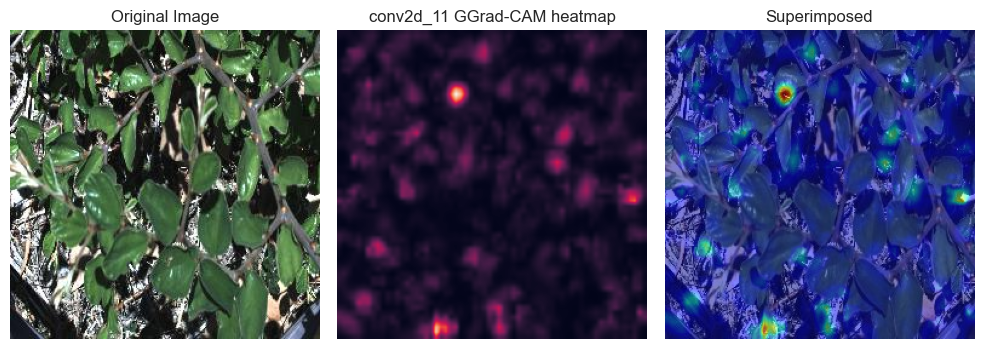

In [14]:
preds = model.predict(np.expand_dims(image, axis=0))
print("Predicted:", decode_predictions(preds, top=1)[0])
show_grad_cam(model, image, last_layer, alpha=1)

### Effects of Darkness/Shadow

In [15]:
image = np.array(Image.open("final_images/test/chinese_apple/20161207-111112-0.jpg"))

1/1 [==============================] - 0s 47ms/step
Predicted: [(0, 'chinese_apple', 0.9952845)]
1/1 [==============================] - 0s 39ms/step
Predicted: [(0, 'chinese_apple', 0.98075265)]
1/1 [==============================] - 0s 37ms/step
Predicted: [(0, 'chinese_apple', 0.9271458)]
1/1 [==============================] - 0s 36ms/step
Predicted: [(0, 'chinese_apple', 0.72153074)]
1/1 [==============================] - 0s 39ms/step
Predicted: [(3, 'parkinsonia', 0.6723404)]


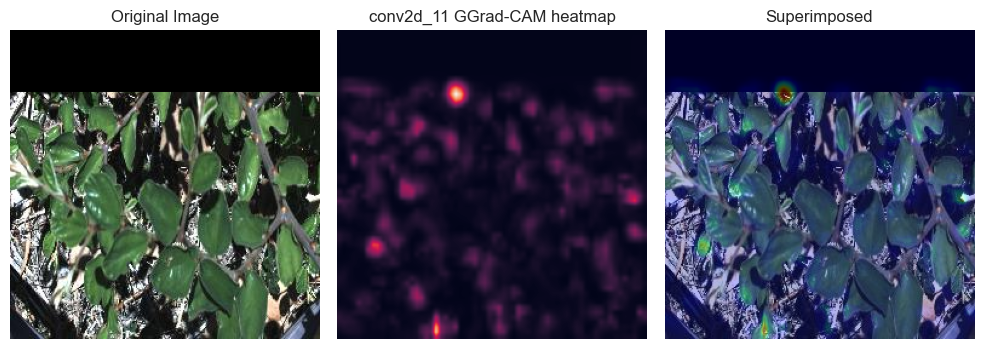

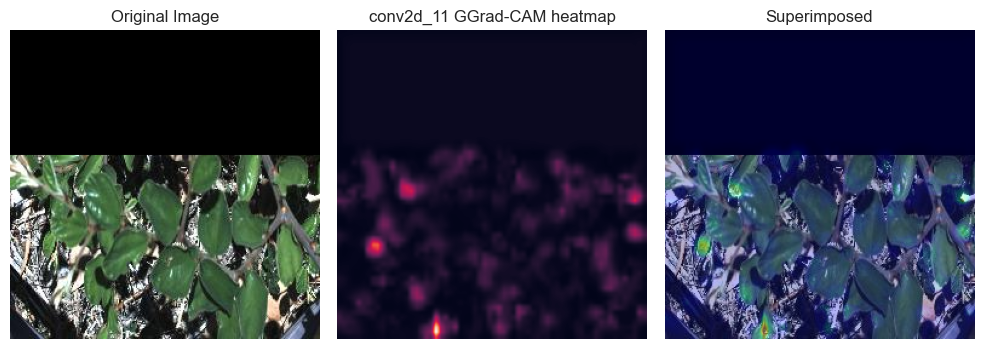

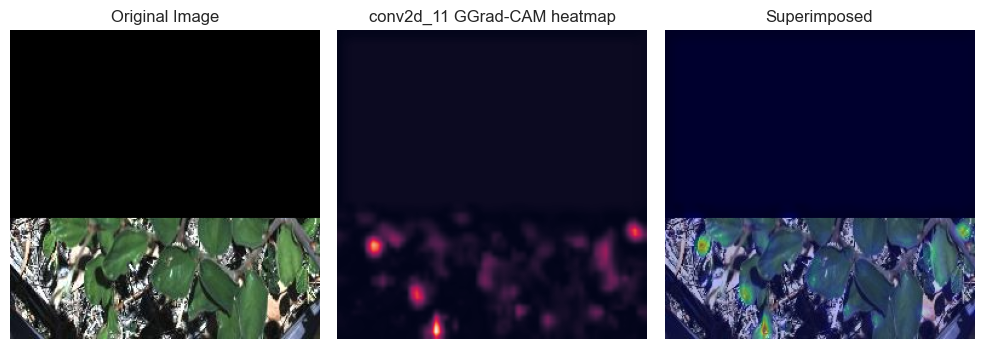

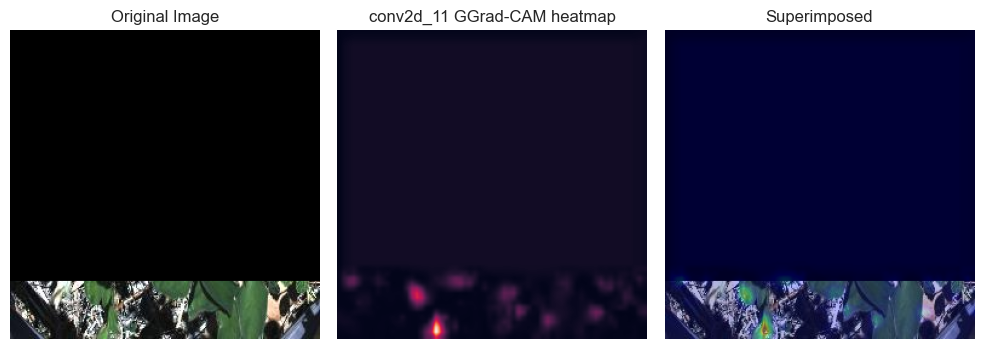

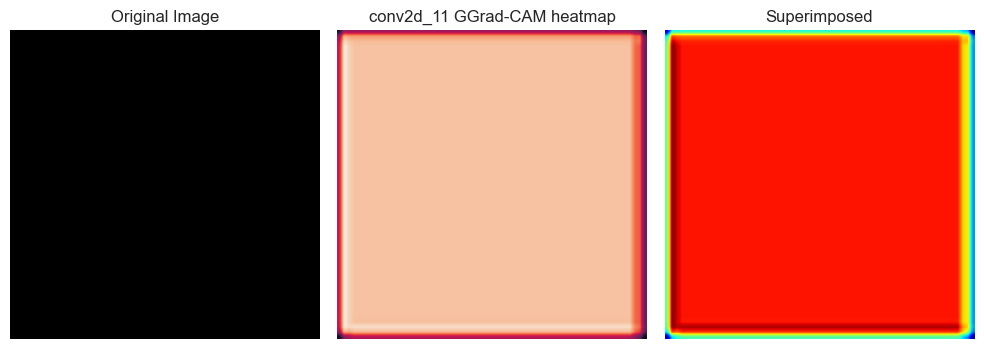

In [16]:
for i in range(5):
    image[i * 52 : (i + 1) * 52] = np.zeros((256,3))
    preds = model.predict(np.expand_dims(image, axis=0))
    print("Predicted:", decode_predictions(preds, top=1)[0])
    show_grad_cam(model, image, last_layer)

### Effects of White/Brightness

In [17]:
image = np.array(Image.open("final_images/test/chinese_apple/20161207-111112-0.jpg"))

1/1 [==============================] - 0s 44ms/step
Predicted: [(0, 'chinese_apple', 0.9822244)]
1/1 [==============================] - 0s 49ms/step
Predicted: [(0, 'chinese_apple', 0.47978517)]
1/1 [==============================] - 0s 42ms/step
Predicted: [(7, 'siam_weed', 0.90701354)]
1/1 [==============================] - 0s 39ms/step
Predicted: [(7, 'siam_weed', 0.8144841)]
1/1 [==============================] - 0s 35ms/step
Predicted: [(2, 'negative', 0.79939115)]


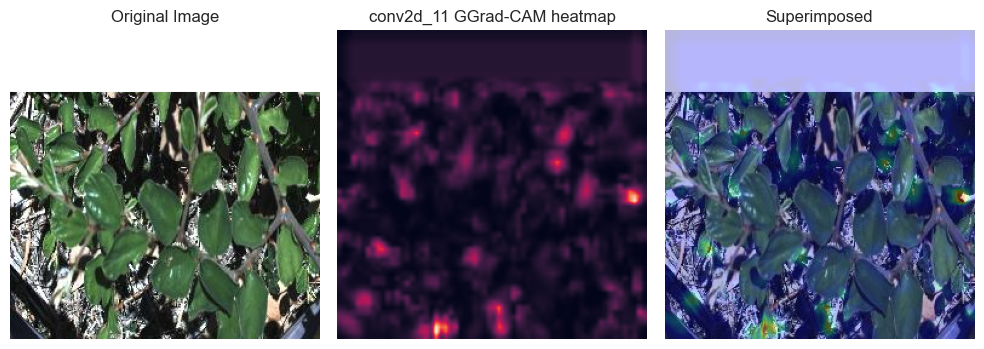

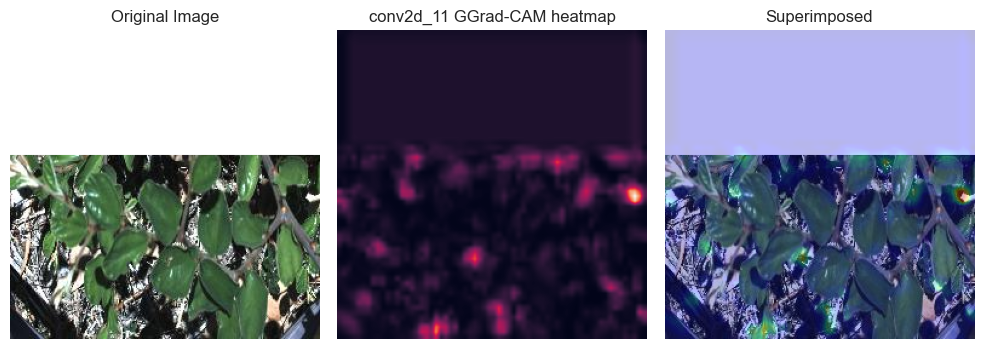

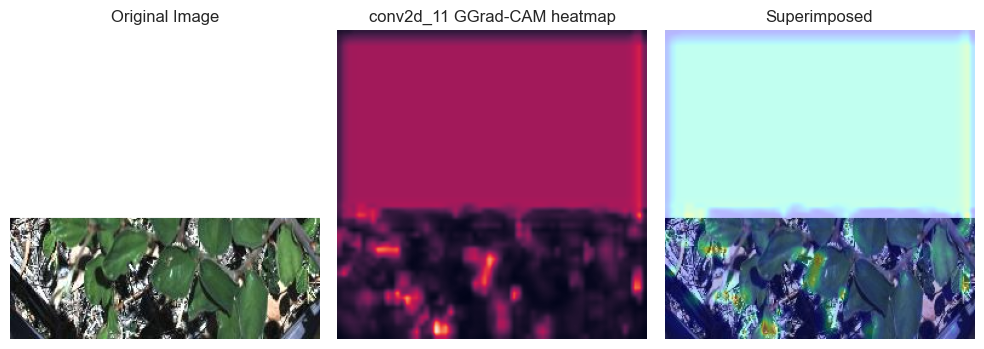

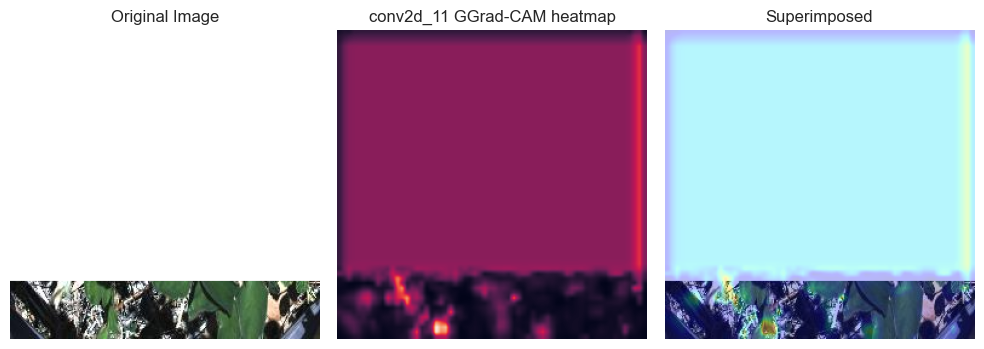

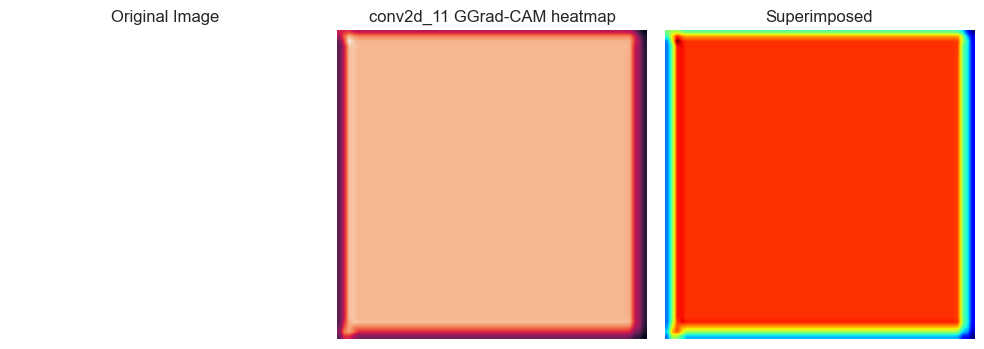

In [18]:
for i in range(5):
    image[i * 52 : (i + 1) * 52] = np.full((256,3), 255)
    preds = model.predict(np.expand_dims(image, axis=0))
    print("Predicted:", decode_predictions(preds, top=1)[0])
    show_grad_cam(model, image, last_layer)